# Résolution de problèmes par l'exploration

Dans ce sujet de TP, sur 4 séances, nous allons voir comment implémenter la formalisation d'un problème de résolution par l'exploration ainsi que les différents algorithmes de recherche vus en cours puis en TD. Nous verrons enfin comment utiliser cela pour effectuer la résolution de labyrinthes et de jeux de taquin.


In [219]:
from numpy.random import randint
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations
from queue import PriorityQueue

# Définition d'un problème

On commence par définir une classe abstraite pour représenter un `Problem` qui sera résolu par l'exploration.

On indique l'état initial et soit l'état final (s'il y en a un seul), soit la manière de savoir si on se trouve dans un état final (en redéfinissant la méthode `is_goal`, dans la sous-classe qui implémente la classe `Problem`). La sous-classe devra également implémenter le constructeur `__init__`(en ajoutant éventuellement d'autres paramètres) et les méthodes `actions`, `result` et `action_cost`. 


In [220]:
class Problem:
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other arguments for the subclass."""


    def __init__(self, initial=None, goal=None): 
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal
        
    def actions(self, state):     
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""   
        raise NotImplementedError
    
    def result(self, state, action): 
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError
    
    def is_goal(self, state):   
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor."""     
        return state == self.goal
    
    def action_cost(self, s, a, s1): 
        """Return the cost of an action a from state s to state s1."""
        return 1
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

# Définition d'un arbre de recherche

Un arbre de recherche est défini par la classe `Node`, qui définit le noeud racine de l'arbre de recherche et ses sous-arbres fils.

## Définition d'un noeud

Dans la classe `Node`, on définit un noeud dans un arbre de recherche.
Le noeud contient un pointeur vers son noeud parent `parent` ainsi que vers l'état `state` auquel il correspond (la notion d'état sera défini au moment de la définition du problème représenté). Il est à noter que si un état peut être atteint par 2 chemins, il y aura alors 2 noeuds contenant le même état. Le noeud contient également l'action `action` qui a permis d'atteindre l'état associé au noeud ainsi que le coût total `path_cost` du chemin allant du noeud initial au noeud courant (correspondant à la valeur g dans les algorithmes d'exploration).

In [221]:
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    def __repr__(self): 
        return '<{}>'.format(self.state)
    
    def __len__(self): 
        return 0 if self.parent is None else (1 + len(self.parent))
    
    def __lt__(self, other): 
        return self.path_cost < other.path_cost
    

## Fonctions relatives aux noeuds d'un arbre de recherche

On définit également quelques fonctions sur les noeuds : `expand` pour générer les noeuds successeurs d'un noeud donné, `path_actions` pour récupérer la liste d'actions ayant permis d'arriver jusqu'au noeud et `path_states` pour récupérer la liste des états ayant permis d'arriver jusqu'au noeud.

### Question 3 : compléter ces 3 fonctions

In [222]:
def expand(problem, node):
    "Expand a node, generating the children nodes (see slide 18 in the lecture)."
    nodes = []
    for action in problem.actions(node.state):
        nodes.append( Node(  
            state=problem.result(node.state, action),
            parent=node,
            action=action,
            path_cost=node.path_cost + problem.action_cost(
                node.state, action,
                problem.result(node.state, action))))
    return nodes

        

def path_actions(node):
    "The list of actions to get to this node."
    actions = []
    while node.parent is not None:
        actions.append(node.action)
        node = node.parent
    actions.reverse()
    return actions



def path_states(node):
    "The list of states to get to this node."
    states = []
    states.append(node.state)
    while node.parent is not None:
        node = node.parent
        states.append(node.state)
    states.reverse()
    return states

# Algorithmes de recherche

Les algorithmes de recherche non-informée (exploration en largeur et exploration en profondeur, en mémorisant ou non les états déjà exploras) ainsi que les algorithmes de recherche informée (exploration gloutonne et A*) seront implémentés ici.

In [223]:
# Noeud particulier pour indiquer qu'un algorithme ne peut pas trouver de solution    
failure = Node('failure', path_cost=math.inf)

## Différents types de files pour implémenter la frontière

Les files FIFO et LIFO sont utilisées, respectivement, pour implémenter la `frontière` dans l'exploration en largeur et dans l'exploration en profondeur. La file de priorié `PriorityQueue` est utilisée dans l'exploration gloutonne et dans l'exploration A* pour garder la frontière triée en fonction du score croissant `f(item)`.

In [224]:
FIFOQueue = deque

LIFOQueue = list


## Exploration en largeur de l'arbre de recherche

### Question 5 : implémenter l'exploration en largeur de l'arbre de recherche (voir slides 18 et 20 du cours)

In [225]:
def breadth_first_tree_search(problem):
    """Search the shallowest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Repeats infinitely in case of loops."""

    frontier = FIFOQueue()
    visited = []
    frontier.append(Node(problem.initial))
    while frontier[0] != problem.goal :
        for action in problem.actions(problem.initial):
            if problem.result(problem.initial, action) not in visited:
                frontier.append( Node(  
                    state=problem.result(problem.initial, action),
                    parent=None,
                    action=action,
                    path_cost=problem.action_cost(
                        problem.initial, action,
                        problem.result(problem.initial, action))))
            visited.append(frontier[-1].state)
        if not frontier:
            return failure
        node = frontier.popleft()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            if child.state not in visited :
                frontier.append(child)
    return failure 
    

## Exploration en profondeur de l'arbre de recherche

### Question 7 : implémenter l'exploration en profondeur de l'arbre de recherche (voir slides 18 et 21 du cours)

In [226]:
def depth_first_tree_search(problem):
    """Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Repeats infinitely in case of loops.
    """
    frontier = []
    visited = [problem.initial]
    frontier.append(Node(problem.initial))
    while frontier[-1] != problem.goal :
        for action in problem.actions(problem.initial):
            if problem.result(problem.initial, action) not in visited:
                frontier.append( Node(  
                    state=problem.result(problem.initial, action),
                    parent=None,
                    action=action,
                    path_cost=problem.action_cost(
                        problem.initial, action,
                        problem.result(problem.initial, action))))
            visited.append(frontier[-1].state)
            
        if not frontier:
            return failure
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        
        for child in expand(problem, node):
            if child.state not in visited:
               frontier.append(child)
    return failure 

## Exploration en largeur du graphe des états

### Question 8 : implémenter l'exploration en largeur du graphe des états (voir slide 27 du cours)

In [227]:
def breadth_first_graph_search(problem):
    """Search the shallowest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """
    raise NotImplementedError

## Exploration en profondeur du graphe des états

### Question 9 : implémenter l'exploration en profondeur du graphe des états (voir slide 27 du cours)

In [228]:
def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """
    raise NotImplementedError

## Exploration gloutonne du graphe des états

### Question 10 : implémenter l'exploration gloutonne du graphe des états (voir slides 27 et 34 du cours)

In [229]:
def greedy_graph_search(problem, h=None):
    """Search nodes with minimum h(n)."""
    while problem.state != problem.goal :
        
        raise NotImplementedError

## Exploration A* du graphe des états

### Question 11 : implémenter l'exploration A* du graphe des états (voir slides 27 et 37 du cours)

In [230]:
def astar_graph_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    raise NotImplementedError

# Résolution de labyrinthes

La résolution d'un problème de type labyrinthe implique de naivguer dans une grille 2D avec des cases pouvant contenir des murs dans les 4 directions autour de chaque case (nord, est, sud et ouest). 

## Définition d'une classe représentant un labyrinthe

On commence par définir la classe `Cell` (pour représenter les cases d'un labyrinthe) puis la classe `Labyrinth` pour représenter le labyrinthe constitué de cases.

In [231]:
from numpy.random import randint
import matplotlib.pyplot as plt


class Stack:
    """ définition d'une pile à l'aide de la classe List """
    def __init__(self, lst=[]):
        self.lst = lst

    def empty(self):
        return self.lst == []

    def push(self, x):
        self.lst.append(x)

    def pop(self):
        if self.empty():
            raise ValueError("pile vide")
        return self.lst.pop()


class Cell:
    def __init__(self, N=False, E=False, S=False, W=False):
        self.N = N
        self.E = E
        self.S = S
        self.W = W
    

class Labyrinth:
    def __init__(self, p, q, tab=None):
        self.p = p
        self.q = q
        if tab == None:
            self.tab = [[Cell() for j in range(q)] for i in range(p)]
        else:
            self.tab = tab
        
    def entrance(self):
        return (0, 0)

    def exit(self):
        return (self.p-1, self.q-1)

    def create(self):
        pile = Stack()
        dejavu = [[False for j in range(self.q)] for i in range(self.p)]
        i, j = randint(self.p), randint(self.q)
        pile.push((i, j))
        dejavu[i][j] = True
        while not pile.empty():
            (i, j) = pile.pop()
            v = []
            if j < self.q-1 and not dejavu[i][j+1]:
                v.append('E')
            if i > 0 and not dejavu[i-1][j]:
                v.append('N')
            if j > 0 and not dejavu[i][j-1]:
                v.append('W')
            if i < self.p-1 and not dejavu[i+1][j]:
                v.append('S')
            if len(v) > 1:
                pile.push((i, j))
            if len(v) > 0:
                c = v[randint(len(v))]
                if c == 'N':
                    self.tab[i][j].N = True
                    self.tab[i-1][j].S = True
                    dejavu[i-1][j] = True
                    pile.push((i-1, j))
                elif c == 'W':
                    self.tab[i][j].W = True
                    self.tab[i][j-1].E = True
                    dejavu[i][j-1] = True
                    pile.push((i, j-1))
                elif c == 'S':
                    self.tab[i][j].S = True
                    self.tab[i+1][j].N = True
                    dejavu[i+1][j] = True
                    pile.push((i+1, j))
                else:
                    self.tab[i][j].E = True
                    self.tab[i][j+1].W = True
                    dejavu[i][j+1] = True
                    pile.push((i, j+1))

    def show(self, sol=Stack()):
        fig = plt.figure(1, figsize=(self.q/3.2, self.p/3.2))
        ax = fig.add_subplot(111)
        ax.axis([-1, self.q+1, -1, self.p+1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.plot([0, 0, self.q, self.q, 0],
                 [0, self.p, self.p, 0, 0], linewidth=2)
        for i in range(self.p-1):
            for j in range(self.q):
                if not self.tab[i][j].S:
                    ax.plot([j, j+1], [self.p-i-1, self.p-i-1], 'b')
        for j in range(self.q-1):
            for i in range(self.p):
                if not self.tab[i][j].E:
                    ax.plot([j+1, j+1], [self.p-i, self.p-i-1], 'b')
        if not sol.empty():
            X, Y = [], []
            while not sol.empty():
                (i, j) = sol.pop()
                X.append(j+.5)
                Y.append(self.p-i-.5)
            ax.plot(X, Y, 'r', linewidth=2)
        plt.show()

### Test de la classe Labyrinth

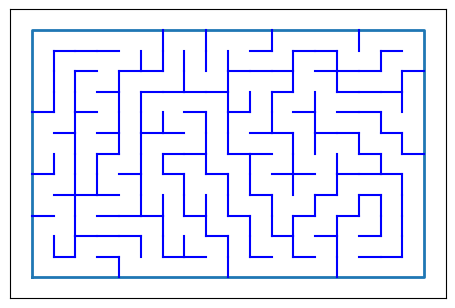

entrée : (0, 0)
sortie : (11, 17)


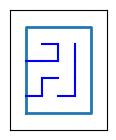

False
entrée : (0, 0)
sortie : (4, 3)


In [232]:
# création et affichage d'un labyrinthe généré aléatoirement à partir de la taille souhaitée
lab1 = Labyrinth(12, 18)
lab1.create()
lab1.show()

print("entrée : " + str(lab1.entrance()))
print("sortie : " + str(lab1.exit()))


# création et affichage d'un labyrinthe à partir d'un tableau de cellules, indiquant les murs autour de chaque case
tab = [
    [Cell(False, True, True, False), Cell(False, True, False, True), Cell(False, True, True, True), Cell(False, False, True, True)],
    [Cell(True, True, False, False), Cell(False, False, False, True), Cell(True, False, True, False), Cell(True, False, True, False)],
    [Cell(False, True, True, False), Cell(False, True, False, True), Cell(True, False, True, True), Cell(True, False, True, False)],
    [Cell(True, False, False, False), Cell(False, True, True, False), Cell(False, False, False, True), Cell(True, False, True, False)],
    [Cell(False, True, False, False), Cell(True, True, False, True), Cell(False, True, False, True), Cell(True, False, False, True)],
]

lab2 = Labyrinth(5, 4, tab)
lab2.show()
print(lab2.tab[0][0].N)

print("entrée : " + str(lab2.entrance()))
print("sortie : " + str(lab2.exit()))


## Définition d'une classe de résolution d'un labyrinthe

Il est nécessaire d'avoir un attribut `labyrinth` pour représenter le labyrinthe.

Les états sont les positions des cellules sous la forme `(x, y)`, comme par exemple, `(4, 2)`. 

Les actions peuvent, par exemple, être représentées par des chaînes de caractères `H`, `B`, `G` et `D`, correspondant aux actions "haut", "bas", "gauche" et "droite".

### Question 1 : compléter les méthodes de la classe `LabyrinthProblem`, en reprenant celles de la classe `Problem` que vous souhaitez implémenter

In [233]:
class LabyrinthProblem(Problem):
    
    def __init__(self, labyrinth):
        super().__init__(initial=labyrinth.entrance(), goal=labyrinth.exit())
        self.labyrinth = labyrinth
    
        
    def actions(self, state):
        state_x, state_y = state
        possible_actions = []
        if self.labyrinth.tab[state_x][state_y].N:
            possible_actions.append("H")
        if self.labyrinth.tab[state_x][state_y].E:
            possible_actions.append("D")
        if self.labyrinth.tab[state_x][state_y].S:
            possible_actions.append("B")
        if self.labyrinth.tab[state_x][state_y].W:
            possible_actions.append("G")
        return possible_actions
    
    
    def result(self, state, action): 
        """Both states and actions are represented by (x, y) pairs. 
            On suppose que l'action est forcément possible, à partir de l'état state.
        """
        match action : 
            case "H" :
                return (state[0] - 1, state[1])
            case "D" :
                return (state[0], state[1] + 1)
            case "B" :
                return (state[0] + 1, state[1])
            case "G" :
                return (state[0], state[1] - 1) 
    
    
    
    def h(self, node):
        """The Manhattan heuristic."""
        return abs(node.state[0] - self.goal[0]) + abs(node.state[1] - self.goal[1])



# autres fonctions

def g(n): 
    return n.path_cost

### Question 2 : tester les méthodes implémentées dans la classe `LabyrinthProblem`, en utilisant le labyrinthe `lab2`

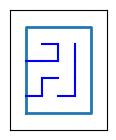

['D', 'B']
(1, 0)
(0, 1)
7


In [234]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()

init_state = labProb2.initial

# test de la méthode actions()
print(labProb2.actions(init_state)) # doit retourner ['D', 'B']

# test de la méthode result()
print(labProb2.result(init_state, 'B')) # doit retourner (1,0)
print(labProb2.result(init_state, 'D')) # doit retourner (0,1)

# test de la méthode h()
print(labProb2.h(Node(init_state))) # doit retourner 7

### Question 4 : tester les fonctions implémentées sur les noeuds (à la question 3)

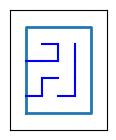

[<(0, 1)>, <(1, 0)>]
['D']
[(0, 0), (0, 1)]


In [235]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()

init_state = labProb2.initial
init_node = Node(init_state)
child_right = Node((0,1), init_node, 'D', 1)

# test de la fonction expand()
print(expand(labProb2, init_node)) # doit retourner [<(0, 1)>, <(1, 0)>], c'est-à-dire les noeuds correspondant aux états (0,1) et (1,0)

# test de la fonction path_actions()
print(path_actions(child_right)) # doit retourner 'D'

# test de la fonction path_states()
print(path_states(child_right)) # doit retourner [(0,0), (0,1)]

## Utilisation de différentes stratégies de résolution de labyrinthes

### Question 6 : tester la résolution de problèmes de labyrinthes, en utilisant la classe `LabyrinthProblem`, ainsi que les fonctions correspondant aux différents algorithmes de recherche + affichage du chemin parcouru, sur le labyrinthe

#### Exploration en largeur (en arbre)


exploration en largeur (en arbre)
	états sur le chemin vers la sortie : [(0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3)]
	actions sur le chemin vers la sortie : ['D', 'D', 'B', 'B', 'B', 'B']


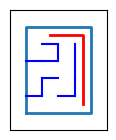

In [236]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
#labProb2.labyrinth.show()

print("\nexploration en largeur (en arbre)")
res2bt = breadth_first_tree_search(labProb2)
etats2bt = path_states(res2bt)
print("\tétats sur le chemin vers la sortie : " + str(etats2bt))
print("\tactions sur le chemin vers la sortie : " + str(path_actions(res2bt)))
labProb2.labyrinth.show(Stack(etats2bt))


#### Exploration en profondeur (en arbre)


exploration en profondeur (en arbre)
	états sur le chemin vers la sortie : [(0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (3, 1), (4, 1), (4, 2), (4, 3)]
	actions sur le chemin vers la sortie : ['D', 'B', 'B', 'B', 'G', 'B', 'D', 'D']


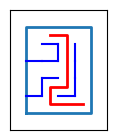

In [237]:
labProb2 = LabyrinthProblem(labyrinth=lab2)

print("\nexploration en profondeur (en arbre)")
res2bt = depth_first_tree_search(labProb2)
etats2bt = path_states(res2bt)
print("\tétats sur le chemin vers la sortie : " + str(etats2bt))
print("\tactions sur le chemin vers la sortie : " + str(path_actions(res2bt)))
labProb2.labyrinth.show(Stack(etats2bt))


### Question 12 : comparer le nombre de noeuds générés et visités, par algorithme

# Résolution de jeux du taquin

## Question 13 : reprener les étapes de la résolution de labyrinthe pour effectuer la résolution de jeu de taquin de taille 3x3 (pour commencer puis plus grands)